# Transfer learning with transformer architecture

The purpose of this notebook is to show how finetuning improves the model's accuracy.  
Dataset used is Physionet MI. The dataset is split into three subdatasets:

- Dataset A (75 subjects)
- Dataset B (15 subjects)
- Dataset C (15 subjects)

Dataset A is used to pretrain the model before finetuning it on dataset B. Dataset C is used for testing.  
Comparison is done between two models for each architecture:

- one is trained on dataset B and tested on dataset C
- second is trained on dataset A, finetuned on dataset B and tested on dataset C

Five experimental runs are done for each transformer to calculate mean accuracy of both models.


In [ ]:
import sys
import os
import warnings
import mne
import torch

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_SHIN_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from torchmetrics.classification import Accuracy

import scripts.transformer.transformer_models as trans
from scripts.dataset.eeg_dataset import EEGDataset
from eeg_logger import logger

import moabb
from moabb.datasets import PhysionetMI

moabb.set_log_level("info")

# Instantiate dataset and load data

MOABB makes working with datasets super easy. With Physionet we can specify which runs we want to analyze using `imagined` and `executed` flags. Setting `imagined` to **True** makes `get_data` method return runs 4, 8, 12, 6, 10, 14 because they contain imaginary tasks. For this work, we only need runs 4, 8, 12 because they contain left and right hand movement. The `get_data` method returns dict structured like this:  
`data[subject_index]["session_index"]["run_index"]`


In [5]:
dataset = PhysionetMI(imagined=True, executed=False)
subject_list = np.delete(np.arange(1, 110), [87, 91, 99, 103])
train_big_subjects = subject_list[:75]
train_small_subjects = subject_list[75:90]
test_subjects = subject_list[90:]
dataset.subject_list = subject_list

print(f"All subjects: {subject_list.shape}")
print(f"Big train datset: {train_big_subjects.shape}")
print(f"Small train dataset: {train_small_subjects.shape}")
print(f"Test datset: {test_subjects.shape}")

train_big_data = dataset.get_data(subjects=train_big_subjects.tolist())
train_small_data = dataset.get_data(subjects=train_small_subjects.tolist())
test_data = dataset.get_data(subjects=test_subjects.tolist())

All subjects: (105,)
Big train datset: (75,)
Small train dataset: (15,)
Test datset: (15,)


# Extract epochs related to motor imagery


In [ ]:
def normalize(epochs: mne.Epochs) -> mne.epochs:
    """
    Applies z-score normalization according to this formula:
    X* = (X - mean) / std + aN
    """

    data: np.ndarray = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
    mean = data.mean(axis=2, keepdims=True)
    std = data.std(axis=2, keepdims=True)
    std[std == 0] = 1.0
    N = np.random.randn(*data.shape)
    a = 0.01

    zscored_data = (data - mean) / std + a * N
    epochs._data = zscored_data

    return epochs


selected_event_id = {"left_hand": 1, "right_hand": 3}  # BASED ON EVENT_IDS
tmin_3s, tmax_3s = 2.0, 5.0
tmin_6s, tmax_6s = 1.0, 7.0
channels = [
    "FC5",
    "FC3",
    "FC1",
    "FC2",
    "FC4",
    "FC6",
    "C5",
    "C3",
    "C1",
    "Cz",
    "C2",
    "C4",
    "C6",
    "CP5",
    "CP3",
    "CP1",
    "CP2",
    "CP4",
    "CP6",
]
epochs_big_dataset = []
epochs_small_dataset = []
epochs_test_dataset = []

for subject in subject_list:
    session_data = None

    if subject in train_big_subjects:
        session_data = train_big_data[subject]["0"]
    elif subject in train_small_subjects:
        session_data = train_small_data[subject]["0"]
    elif subject in test_subjects:
        session_data = test_data[subject]["0"]
    else:
        logger.error(f"Subject {subject} does not belong to any dataset")

    run_4 = session_data["0"]
    run_8 = session_data["1"]
    run_12 = session_data["2"]

    all_runs = mne.concatenate_raws([run_4, run_8, run_12], preload=False)
    events, event_ids = mne.events_from_annotations(all_runs)
    if subject == 1:
        logger.info(f"Event ids: {event_ids}")

    epochs = mne.Epochs(
        all_runs,
        events,
        event_id=selected_event_id,
        tmin=tmin_3s,
        tmax=tmax_3s,
        picks=channels,
        baseline=None,
        preload=True,
    )
    epochs = normalize(epochs)

    if subject in train_big_subjects:
        epochs_big_dataset.append(epochs)
    elif subject in train_small_subjects:
        epochs_small_dataset.append(epochs)
    elif subject in test_subjects:
        epochs_test_dataset.append(epochs)
    else:
        logger.error(f"Subject {subject} does not belong to any dataset")

2025-09-05 13:05:59,101 - INFO - Event ids: {'left_hand': 1, 'rest': 2, 'right_hand': 3}


# Get data and labels from extracted epochs


In [ ]:
USE_WINDOWING = False
N_WINDOWS = 3
WINDOW_OVERLAP = 0.5


def extract_data_from_epochs(epochs: mne.Epochs, label_mapping: dict | None = None) -> tuple[np.ndarray, np.ndarray]:
    X = epochs.get_data()
    y = epochs.events[:, -1]
    if label_mapping:
        y = np.array([label_mapping[label] for label in y])
    return X, y


def window_epochs(epochs, n_windows=N_WINDOWS, overlap=WINDOW_OVERLAP, label_mapping={1: 0, 3: 1}):
    if not 0 <= overlap < 1:
        raise ValueError("Overlap must be between 0 (inclusive) and 1 (exclusive).")

    data = epochs.get_data()
    labels = epochs.events[:, -1]
    n_epochs, _, n_times = data.shape

    windowed_data = []
    windowed_labels = []

    # Calculate window length and step size
    window_length = int(np.floor(n_times / (n_windows - (n_windows - 1) * overlap)))
    step = int(window_length * (1 - overlap))

    for i in range(n_epochs):
        epoch = data[i]
        start_indices = range(0, n_times - window_length + 1, step)
        for start in start_indices:
            end = start + window_length
            windowed_data.append(epoch[:, start:end])
            windowed_labels.append(label_mapping[labels[i]])

    return np.array(windowed_data), np.array(windowed_labels)


X_big_train = []
y_big_train = []

X_small_train = []
y_small_train = []

X_test = []
y_test = []

for epochs in epochs_big_dataset:
    if USE_WINDOWING:
        X, y = window_epochs(epochs, n_windows=N_WINDOWS, overlap=WINDOW_OVERLAP, label_mapping={1: 0, 3: 1})
    else:
        X, y = extract_data_from_epochs(epochs, label_mapping={1: 0, 3: 1})
    X_big_train.append(X)
    y_big_train.append(y)
for epochs in epochs_small_dataset:
    if USE_WINDOWING:
        X, y = window_epochs(epochs, n_windows=N_WINDOWS, overlap=WINDOW_OVERLAP, label_mapping={1: 0, 3: 1})
    else:
        X, y = extract_data_from_epochs(epochs, label_mapping={1: 0, 3: 1})
    X_small_train.append(X)
    y_small_train.append(y)
for epochs in epochs_test_dataset:
    if USE_WINDOWING:
        X, y = window_epochs(epochs, n_windows=N_WINDOWS, overlap=WINDOW_OVERLAP, label_mapping={1: 0, 3: 1})
    else:
        X, y = extract_data_from_epochs(epochs, label_mapping={1: 0, 3: 1})
    X_test.append(X)
    y_test.append(y)

X_big_train = np.concatenate(X_big_train)
y_big_train = np.concatenate(y_big_train)
X_small_train = np.concatenate(X_small_train)
y_small_train = np.concatenate(y_small_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Train and evaluate methods

Here methods for testing and evaluating models are defined. The purpose of this work is to show how finetuning improves accuracy. Five different transformer models are tested.


In [ ]:
from enum import Enum


LR = 7e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 50
FINETUNE_LR = 1e-5
FINETUNE_WEIGHT_DECAY = 0
FINETUNE_EPOCHS = 7


class ModelType(Enum):
    SpatialTransformer = 1
    TemporalTransformer = 2
    SpatialCNNTransformer = 3
    TemporalCNNTransformer = 4
    FusionCNNTransformer = 5


def __is_cnn(model_type: ModelType) -> bool:
    return model_type in [
        ModelType.SpatialCNNTransformer,
        ModelType.TemporalCNNTransformer,
        ModelType.FusionCNNTransformer,
    ]


def build_model(model_type: ModelType, X_train: np.ndarray) -> torch.nn.Module:
    model = None
    match (model_type):
        case ModelType.SpatialTransformer:
            model = trans.SpatialTransformer(input_size=X_train.shape[2], d_model=64, num_heads=8, num_classes=2)
        case ModelType.TemporalTransformer:
            model = trans.TemporalTransformer(input_size=X_train.shape[1], d_model=64, num_heads=8, num_classes=2)
        case ModelType.SpatialCNNTransformer:
            model = trans.SpatialCNNTransformer(d_model=64, num_heads=8, num_classes=2)
        case ModelType.TemporalCNNTransformer:
            model = trans.TemporalCNNTransformer(d_model=64, num_heads=8, num_classes=2)
        case ModelType.FusionCNNTransformer:
            model = trans.FusionCNNTransformer(d_model=64, num_heads=8, num_classes=2)
        case _:
            logger.error("Wrong model type!")
            return
    return model


def __train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epochs: int = EPOCHS,
    verbose: bool = False,
) -> torch.nn.Module:
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    train_acc = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)

        train_losses.append(total_loss / len(train_loader.dataset))

        accuracy = 0
        if USE_WINDOWING:
            accuracy = evaluate_model_epoch_level(model, device, test_loader)
        else:
            accuracy = evaluate_model(model, device, test_loader)
        train_acc.append(accuracy)

        if verbose:
            logger.info(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    return train_losses, train_acc


def train_and_evaluate_model(
    model_type: ModelType,
    device: torch.device,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    X_finetune: np.ndarray = None,
    y_finetune: np.ndarray = None,
):
    cnn_mode = __is_cnn(model_type)
    train_loader = torch.utils.data.DataLoader(
        EEGDataset(X_train, y_train, cnn_mode=cnn_mode),
        batch_size=32,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        EEGDataset(X_test, y_test, cnn_mode=cnn_mode), batch_size=32, shuffle=False
    )

    model = build_model(model_type, X_train)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    train_losses, train_acc = __train_model(model, train_loader, test_loader, optimizer, device, epochs=50)

    if X_finetune is not None and y_finetune is not None:
        train_loader_ft = torch.utils.data.DataLoader(
            EEGDataset(X_finetune, y_finetune, cnn_mode=cnn_mode), batch_size=32, shuffle=True
        )
        finetune_optimizer = torch.optim.Adam(model.parameters(), lr=FINETUNE_LR, weight_decay=FINETUNE_WEIGHT_DECAY)
        _, train_acc_ft = __train_model(
            model, train_loader_ft, test_loader, finetune_optimizer, device, epochs=FINETUNE_EPOCHS
        )
        train_acc += train_acc_ft

    accuracy = 0
    if USE_WINDOWING:
        accuracy = evaluate_model_epoch_level(model, device, test_loader)
    else:
        accuracy = evaluate_model(model, device, test_loader)

    return model, accuracy, train_losses, train_acc


def evaluate_model(model: torch.nn.Module, device: torch.device, test_loader: torch.utils.data.DataLoader) -> float:
    """
    Computes accuracy of provided model.
    """
    acc = Accuracy(task="binary").to(device)
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            preds = torch.argmax(output, dim=1)
            acc.update(preds, y_batch)

    return acc.compute().item()


def evaluate_model_epoch_level(
    model: torch.nn.Module,
    device: torch.device,
    test_loader: torch.utils.data.DataLoader,
    n_windows: int = N_WINDOWS,
) -> float:
    """
    Computes epoch-level accuracy.
    Assumes each epoch has exactly `n_windows` consecutive windows in the dataset.
    """
    acc = Accuracy(task="binary").to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)  # (batch_size, n_classes)
            probs = torch.softmax(outputs, dim=1)
            all_preds.append(probs.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds, dim=0)  # (N_windows, n_classes)
    all_labels = torch.cat(all_labels, dim=0)  # (N_windows,)

    # Group into epochs
    num_epochs = len(all_labels) // n_windows
    for i in range(num_epochs):
        start = i * n_windows
        end = start + n_windows
        epoch_probs = all_preds[start:end].mean(dim=0)  # average across windows
        epoch_pred = epoch_probs.argmax().unsqueeze(0)  # shape (1,)
        epoch_label = all_labels[start].unsqueeze(0)  # shape (1,)
        acc.update(epoch_pred, epoch_label)

    return acc.compute().item()


def plot_training_loss(loss: np.ndarray, model_type: ModelType):
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(1, EPOCHS + 1), loss, label="Błąd uczenia", color="blue")
    plt.title(f"Przebieg funkcji błędu uczenia dla modelu {model_type.name}")
    plt.xlabel("Epoka")
    plt.ylabel("Błąd")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_training_acc(acc: np.ndarray, model_type: ModelType):
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(1, EPOCHS + FINETUNE_EPOCHS + 1), acc, label="Dokładność uczenia", color="green")
    plt.axvline(x=EPOCHS, color="red", linestyle="--", label="Start douczania")
    plt.title(f"Przebieg funkcji dokładności uczenia modelu {model_type.name}")
    plt.xlabel("Epoka")
    plt.ylabel("Dokładność (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


runs = 5
model_final_accuracies = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    logger.warning("Warning - training will be done on cpu")
else:
    logger.info("Training will be done on gpu")

2025-09-05 13:06:18,403 - INFO - Training will be done on gpu


# Training and evaluating Spatial transformer


2025-09-05 13:06:22,819 - INFO - Run 1/5
2025-09-05 13:06:36,919 - INFO - Accuracy for SpatialTransformer without finetuning: 54.92%
2025-09-05 13:07:26,020 - INFO - Accuracy for SpatialTransformer with finetuning: 62.06%
2025-09-05 13:07:26,021 - INFO - Run 2/5
2025-09-05 13:07:38,364 - INFO - Accuracy for SpatialTransformer without finetuning: 52.70%
2025-09-05 13:08:26,144 - INFO - Accuracy for SpatialTransformer with finetuning: 60.48%
2025-09-05 13:08:26,146 - INFO - Run 3/5
2025-09-05 13:08:38,185 - INFO - Accuracy for SpatialTransformer without finetuning: 53.49%
2025-09-05 13:09:25,138 - INFO - Accuracy for SpatialTransformer with finetuning: 61.59%
2025-09-05 13:09:25,139 - INFO - Run 4/5
2025-09-05 13:09:37,285 - INFO - Accuracy for SpatialTransformer without finetuning: 53.17%
2025-09-05 13:10:23,898 - INFO - Accuracy for SpatialTransformer with finetuning: 64.29%
2025-09-05 13:10:23,900 - INFO - Run 5/5
2025-09-05 13:10:36,053 - INFO - Accuracy for SpatialTransformer withou

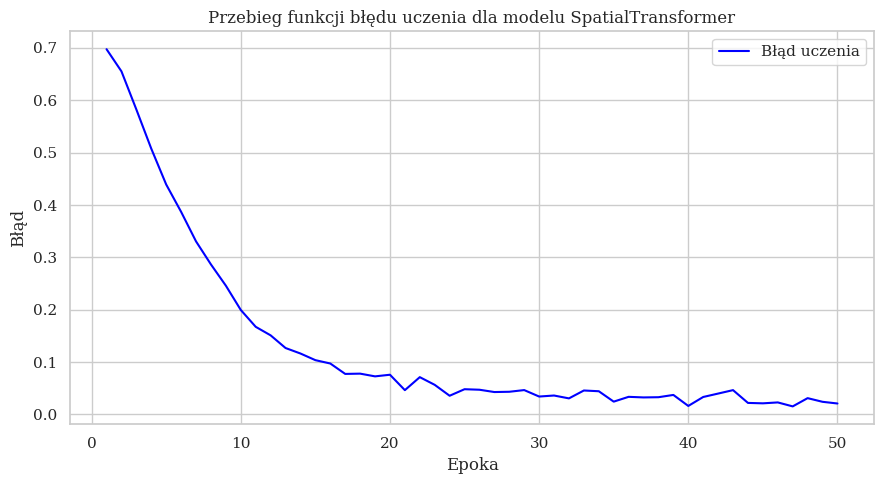

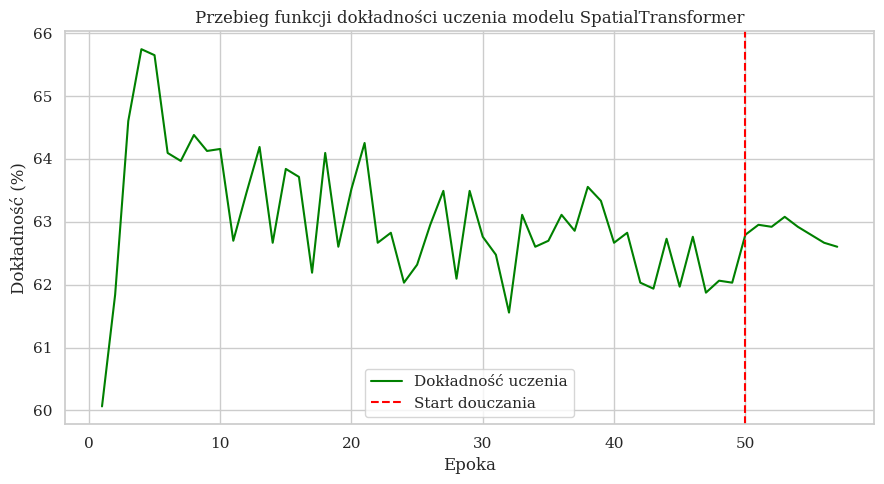

In [9]:
accuracies_no_finetune = []
accuracies_finetune = []
all_losses = []
all_train_acc = []
model_type = ModelType.SpatialTransformer

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, accuracy, _, _ = train_and_evaluate_model(model_type, device, X_small_train, y_small_train, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    # ACCUMULATE LOSS AND ACCURACY OVER EPOCHS FOR FINETUNED MODEL
    model, accuracy, train_losses, train_acc = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_test, y_test, X_small_train, y_small_train
    )
    all_losses.append(train_losses)
    all_train_acc.append([i * 100 for i in train_acc])

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = round(np.mean(accuracies_no_finetune) * 100, 2)
std_no_finetune = round(np.std(accuracies_no_finetune) * 100, 2)
acc_mean_finetune = round(np.mean(accuracies_finetune) * 100, 2)
std_finetune = round(np.std(accuracies_finetune) * 100, 2)

logger.info(f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune}% +- {std_no_finetune}%")
logger.info(f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune}% +- {std_finetune}%")

mean_loss = np.mean(np.array(all_losses), axis=0)
mean_train_acc = np.mean(np.array(all_train_acc), axis=0)

plot_training_loss(mean_loss, model_type)
plot_training_acc(mean_train_acc, model_type)

model_final_accuracies[f"{model_type}"] = acc_mean_no_finetune
model_final_accuracies[f"{model_type}_finetune"] = acc_mean_finetune

# Training and evaluating Temporal Transformer


2025-09-05 13:45:43,937 - INFO - Run 1/5
2025-09-05 13:47:24,269 - INFO - Accuracy for TemporalTransformer without finetuning: 62.06%
2025-09-05 13:54:04,608 - INFO - Accuracy for TemporalTransformer with finetuning: 66.51%
2025-09-05 13:54:04,609 - INFO - Run 2/5
2025-09-05 13:55:44,996 - INFO - Accuracy for TemporalTransformer without finetuning: 62.70%
2025-09-05 14:02:26,766 - INFO - Accuracy for TemporalTransformer with finetuning: 67.14%
2025-09-05 14:02:26,767 - INFO - Run 3/5
2025-09-05 14:04:07,663 - INFO - Accuracy for TemporalTransformer without finetuning: 63.65%
2025-09-05 14:10:49,917 - INFO - Accuracy for TemporalTransformer with finetuning: 68.89%
2025-09-05 14:10:49,921 - INFO - Run 4/5
2025-09-05 14:12:29,932 - INFO - Accuracy for TemporalTransformer without finetuning: 62.54%
2025-09-05 14:19:11,113 - INFO - Accuracy for TemporalTransformer with finetuning: 65.56%
2025-09-05 14:19:11,115 - INFO - Run 5/5
2025-09-05 14:20:51,511 - INFO - Accuracy for TemporalTransform

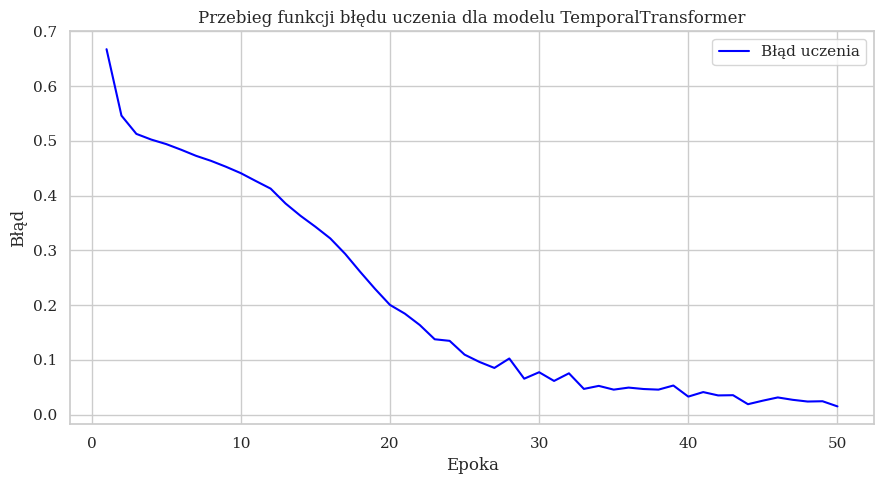

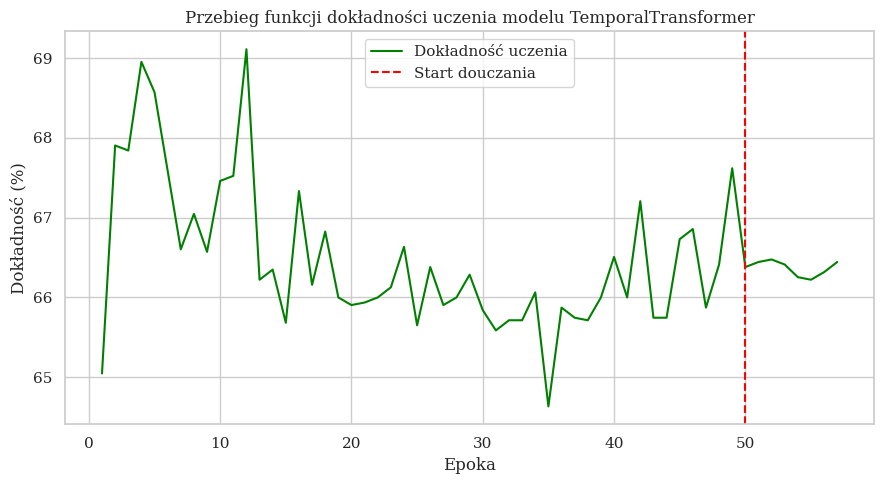

In [13]:
accuracies_no_finetune = []
accuracies_finetune = []
all_losses = []
all_train_acc = []
model_type = ModelType.TemporalTransformer

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, accuracy, _, _ = train_and_evaluate_model(model_type, device, X_small_train, y_small_train, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    # ACCUMULATE LOSS AND ACCURACY OVER EPOCHS FOR FINETUNED MODEL
    model, accuracy, train_losses, train_acc = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_test, y_test, X_small_train, y_small_train
    )
    all_losses.append(train_losses)
    all_train_acc.append([i * 100 for i in train_acc])

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = round(np.mean(accuracies_no_finetune) * 100, 2)
std_no_finetune = round(np.std(accuracies_no_finetune) * 100, 2)
acc_mean_finetune = round(np.mean(accuracies_finetune) * 100, 2)
std_finetune = round(np.std(accuracies_finetune) * 100, 2)

logger.info(f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune}% +- {std_no_finetune}%")
logger.info(f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune}% +- {std_finetune}%")

mean_loss = np.mean(np.array(all_losses), axis=0)
mean_train_acc = np.mean(np.array(all_train_acc), axis=0)

plot_training_loss(mean_loss, model_type)
plot_training_acc(mean_train_acc, model_type)

model_final_accuracies[f"{model_type}"] = acc_mean_no_finetune
model_final_accuracies[f"{model_type}_finetune"] = acc_mean_finetune

# Training and evaluating SpatialCNN transformer


2025-09-05 13:13:49,748 - INFO - Run 1/5
2025-09-05 13:14:08,048 - INFO - Accuracy for SpatialCNNTransformer without finetuning: 61.27%
2025-09-05 13:15:15,264 - INFO - Accuracy for SpatialCNNTransformer with finetuning: 65.40%
2025-09-05 13:15:15,265 - INFO - Run 2/5
2025-09-05 13:15:32,393 - INFO - Accuracy for SpatialCNNTransformer without finetuning: 60.48%
2025-09-05 13:16:39,429 - INFO - Accuracy for SpatialCNNTransformer with finetuning: 64.92%
2025-09-05 13:16:39,430 - INFO - Run 3/5
2025-09-05 13:16:57,207 - INFO - Accuracy for SpatialCNNTransformer without finetuning: 62.38%
2025-09-05 13:18:04,234 - INFO - Accuracy for SpatialCNNTransformer with finetuning: 69.21%
2025-09-05 13:18:04,236 - INFO - Run 4/5
2025-09-05 13:18:21,377 - INFO - Accuracy for SpatialCNNTransformer without finetuning: 63.65%
2025-09-05 13:19:28,442 - INFO - Accuracy for SpatialCNNTransformer with finetuning: 62.06%
2025-09-05 13:19:28,443 - INFO - Run 5/5
2025-09-05 13:19:46,105 - INFO - Accuracy for S

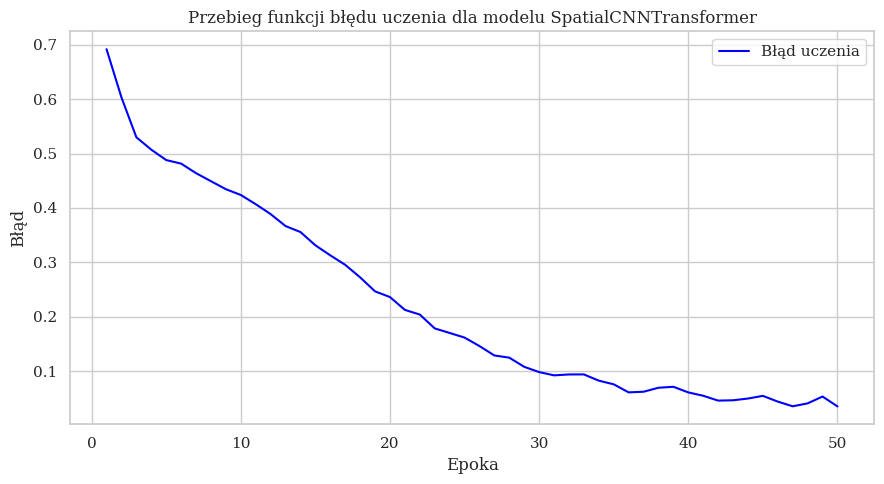

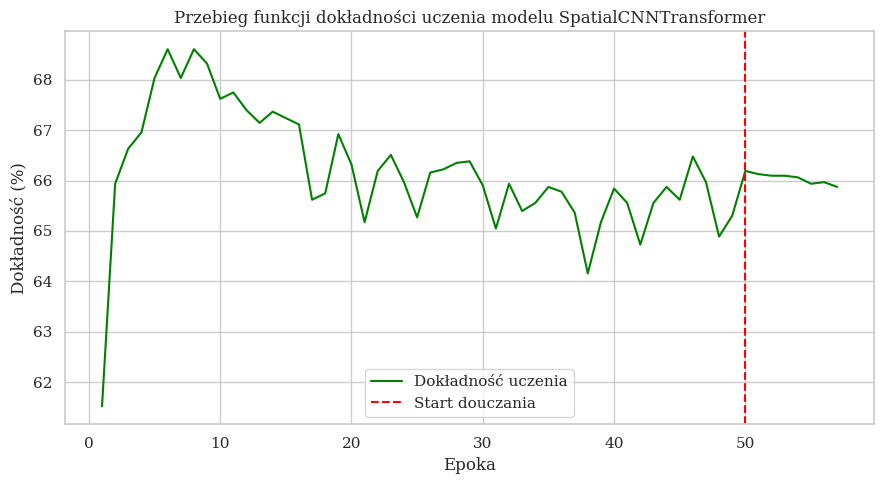

In [10]:
accuracies_no_finetune = []
accuracies_finetune = []
all_losses = []
all_train_acc = []
model_type = ModelType.SpatialCNNTransformer

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, accuracy, _, _ = train_and_evaluate_model(model_type, device, X_small_train, y_small_train, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    # ACCUMULATE LOSS AND ACCURACY OVER EPOCHS FOR FINETUNED MODEL
    model, accuracy, train_losses, train_acc = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_test, y_test, X_small_train, y_small_train
    )
    all_losses.append(train_losses)
    all_train_acc.append([i * 100 for i in train_acc])

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = round(np.mean(accuracies_no_finetune) * 100, 2)
std_no_finetune = round(np.std(accuracies_no_finetune) * 100, 2)
acc_mean_finetune = round(np.mean(accuracies_finetune) * 100, 2)
std_finetune = round(np.std(accuracies_finetune) * 100, 2)

logger.info(f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune}% +- {std_no_finetune}%")
logger.info(f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune}% +- {std_finetune}%")

mean_loss = np.mean(np.array(all_losses), axis=0)
mean_train_acc = np.mean(np.array(all_train_acc), axis=0)

plot_training_loss(mean_loss, model_type)
plot_training_acc(mean_train_acc, model_type)

model_final_accuracies[f"{model_type}"] = acc_mean_no_finetune
model_final_accuracies[f"{model_type}_finetune"] = acc_mean_finetune

# Training and evaluating TemporalCNN transformer


2025-09-05 13:21:46,117 - INFO - Run 1/5
2025-09-05 13:22:03,993 - INFO - Accuracy for TemporalCNNTransformer without finetuning: 56.19%
2025-09-05 13:23:12,595 - INFO - Accuracy for TemporalCNNTransformer with finetuning: 63.81%
2025-09-05 13:23:12,596 - INFO - Run 2/5
2025-09-05 13:23:31,090 - INFO - Accuracy for TemporalCNNTransformer without finetuning: 51.43%
2025-09-05 13:24:41,413 - INFO - Accuracy for TemporalCNNTransformer with finetuning: 66.51%
2025-09-05 13:24:41,418 - INFO - Run 3/5
2025-09-05 13:24:58,751 - INFO - Accuracy for TemporalCNNTransformer without finetuning: 57.46%
2025-09-05 13:26:07,381 - INFO - Accuracy for TemporalCNNTransformer with finetuning: 62.22%
2025-09-05 13:26:07,382 - INFO - Run 4/5
2025-09-05 13:26:25,250 - INFO - Accuracy for TemporalCNNTransformer without finetuning: 54.13%
2025-09-05 13:27:34,057 - INFO - Accuracy for TemporalCNNTransformer with finetuning: 63.97%
2025-09-05 13:27:34,059 - INFO - Run 5/5
2025-09-05 13:27:51,640 - INFO - Accura

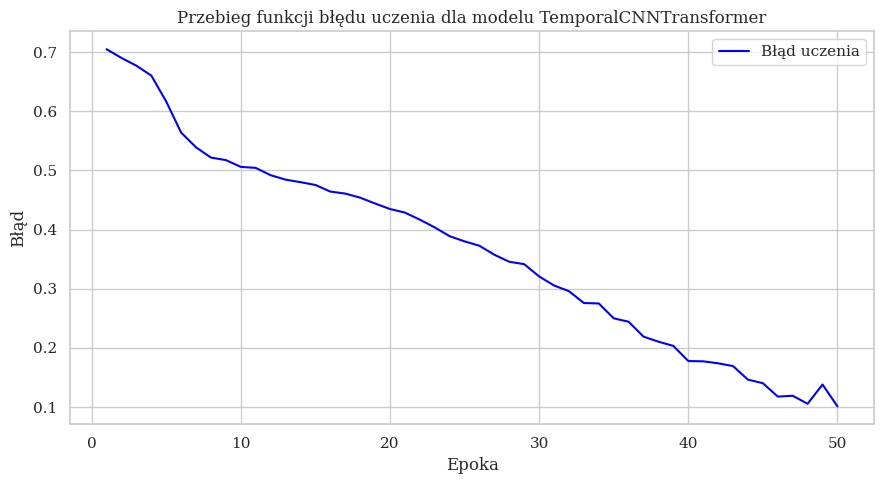

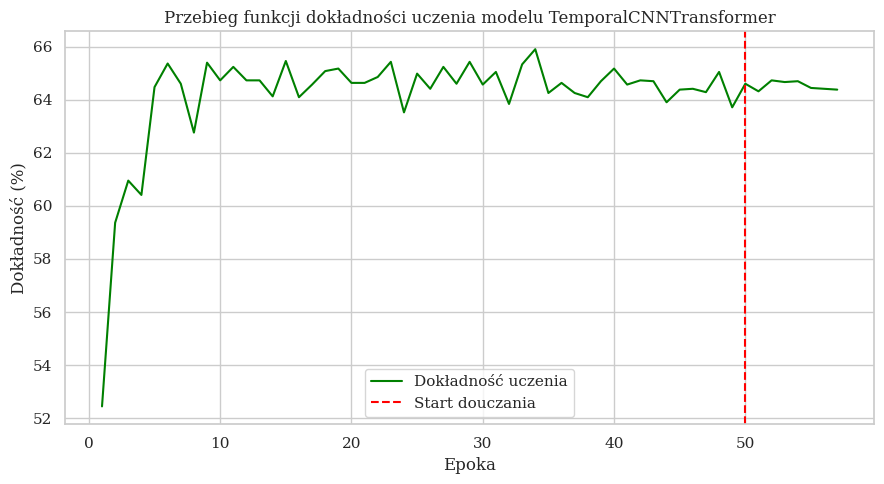

In [11]:
accuracies_no_finetune = []
accuracies_finetune = []
all_losses = []
all_train_acc = []
model_type = ModelType.TemporalCNNTransformer

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, accuracy, _, _ = train_and_evaluate_model(model_type, device, X_small_train, y_small_train, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    # ACCUMULATE LOSS AND ACCURACY OVER EPOCHS FOR FINETUNED MODEL
    model, accuracy, train_losses, train_acc = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_test, y_test, X_small_train, y_small_train
    )
    all_losses.append(train_losses)
    all_train_acc.append([i * 100 for i in train_acc])

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = round(np.mean(accuracies_no_finetune) * 100, 2)
std_no_finetune = round(np.std(accuracies_no_finetune) * 100, 2)
acc_mean_finetune = round(np.mean(accuracies_finetune) * 100, 2)
std_finetune = round(np.std(accuracies_finetune) * 100, 2)

logger.info(f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune}% +- {std_no_finetune}%")
logger.info(f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune}% +- {std_finetune}%")

mean_loss = np.mean(np.array(all_losses), axis=0)
mean_train_acc = np.mean(np.array(all_train_acc), axis=0)

plot_training_loss(mean_loss, model_type)
plot_training_acc(mean_train_acc, model_type)

model_final_accuracies[f"{model_type}"] = acc_mean_no_finetune
model_final_accuracies[f"{model_type}_finetune"] = acc_mean_finetune

# Training and evaluating FusionCNN transformer


2025-09-05 13:30:00,048 - INFO - Run 1/5
2025-09-05 13:30:29,353 - INFO - Accuracy for FusionCNNTransformer without finetuning: 61.90%
2025-09-05 13:32:23,147 - INFO - Accuracy for FusionCNNTransformer with finetuning: 66.03%
2025-09-05 13:32:23,151 - INFO - Run 2/5
2025-09-05 13:32:52,452 - INFO - Accuracy for FusionCNNTransformer without finetuning: 60.63%
2025-09-05 13:34:46,346 - INFO - Accuracy for FusionCNNTransformer with finetuning: 66.03%
2025-09-05 13:34:46,348 - INFO - Run 3/5
2025-09-05 13:35:15,643 - INFO - Accuracy for FusionCNNTransformer without finetuning: 65.08%
2025-09-05 13:37:11,004 - INFO - Accuracy for FusionCNNTransformer with finetuning: 65.56%
2025-09-05 13:37:11,006 - INFO - Run 4/5
2025-09-05 13:37:40,380 - INFO - Accuracy for FusionCNNTransformer without finetuning: 60.48%
2025-09-05 13:39:34,722 - INFO - Accuracy for FusionCNNTransformer with finetuning: 64.44%
2025-09-05 13:39:34,723 - INFO - Run 5/5
2025-09-05 13:40:04,190 - INFO - Accuracy for FusionCNN

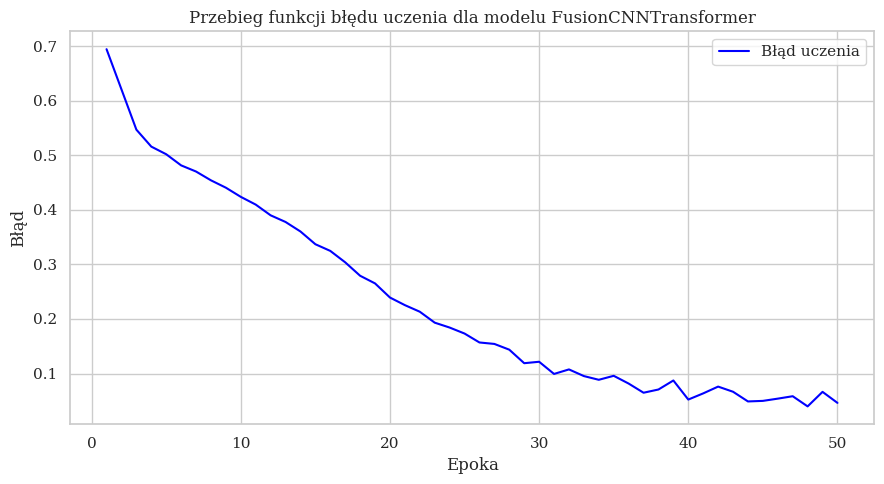

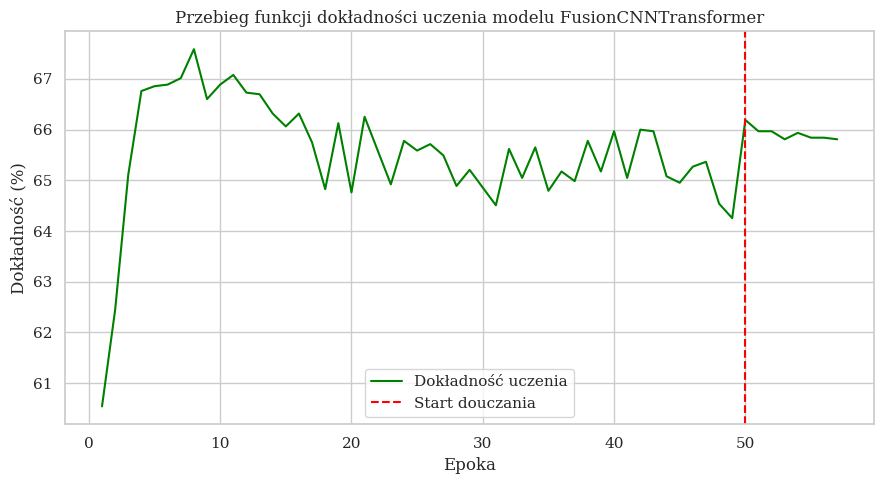

In [12]:
accuracies_no_finetune = []
accuracies_finetune = []
all_losses = []
all_train_acc = []
model_type = ModelType.FusionCNNTransformer

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, accuracy, _, _ = train_and_evaluate_model(model_type, device, X_small_train, y_small_train, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    # ACCUMULATE LOSS AND ACCURACY OVER EPOCHS FOR FINETUNED MODEL
    model, accuracy, train_losses, train_acc = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_test, y_test, X_small_train, y_small_train
    )
    all_losses.append(train_losses)
    all_train_acc.append([i * 100 for i in train_acc])

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = round(np.mean(accuracies_no_finetune) * 100, 2)
std_no_finetune = round(np.std(accuracies_no_finetune) * 100, 2)
acc_mean_finetune = round(np.mean(accuracies_finetune) * 100, 2)
std_finetune = round(np.std(accuracies_finetune) * 100, 2)

logger.info(f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune}% +- {std_no_finetune}%")
logger.info(f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune}% +- {std_finetune}%")

mean_loss = np.mean(np.array(all_losses), axis=0)
mean_train_acc = np.mean(np.array(all_train_acc), axis=0)

plot_training_loss(mean_loss, model_type)
plot_training_acc(mean_train_acc, model_type)

model_final_accuracies[f"{model_type}"] = acc_mean_no_finetune
model_final_accuracies[f"{model_type}_finetune"] = acc_mean_finetune

# Create plot with results


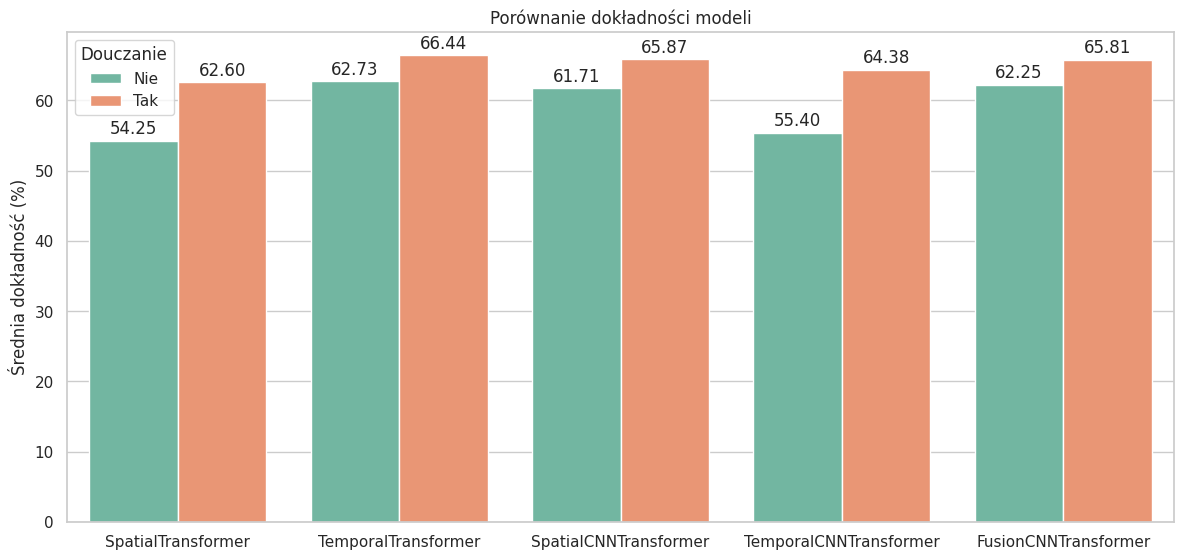

In [25]:
plot_data = {
    "Model": [
        "SpatialTransformer",
        "SpatialTransformer",
        "TemporalTransformer",
        "TemporalTransformer",
        "SpatialCNNTransformer",
        "SpatialCNNTransformer",
        "TemporalCNNTransformer",
        "TemporalCNNTransformer",
        "FusionCNNTransformer",
        "FusionCNNTransformer",
    ],
    "Douczanie": ["Nie", "Tak"] * 5,
    "Średnia dokładność (%)": [
        model_final_accuracies[f"{ModelType.SpatialTransformer}"],
        model_final_accuracies[f"{ModelType.SpatialTransformer}_finetune"],
        model_final_accuracies[f"{ModelType.TemporalTransformer}"],
        model_final_accuracies[f"{ModelType.TemporalTransformer}_finetune"],
        model_final_accuracies[f"{ModelType.SpatialCNNTransformer}"],
        model_final_accuracies[f"{ModelType.SpatialCNNTransformer}_finetune"],
        model_final_accuracies[f"{ModelType.TemporalCNNTransformer}"],
        model_final_accuracies[f"{ModelType.TemporalCNNTransformer}_finetune"],
        model_final_accuracies[f"{ModelType.FusionCNNTransformer}"],
        model_final_accuracies[f"{ModelType.FusionCNNTransformer}_finetune"],
    ],
}

# Create DataFrame
df = pd.DataFrame(plot_data)

# Set plot style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=df, x="Model", y="Średnia dokładność (%)", hue="Douczanie", palette="Set2")

# Annotate bars with values
for container in barplot.containers:
    barplot.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12, padding=2)

# Improve layout
plt.title("Porównanie dokładności modeli")
plt.tight_layout()
plt.xlabel("")
plt.legend(title="Douczanie")

# Show plot
plt.show()

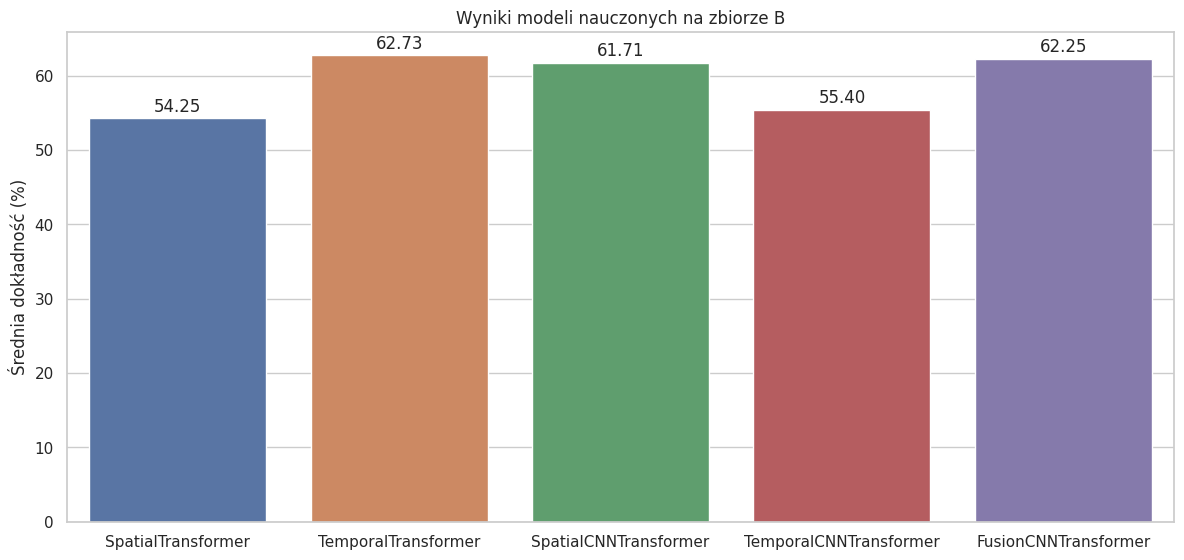

In [20]:
plot_data = {
    "Model": [
        "SpatialTransformer",
        "TemporalTransformer",
        "SpatialCNNTransformer",
        "TemporalCNNTransformer",
        "FusionCNNTransformer",
    ],
    "Średnia dokładność (%)": [
        model_final_accuracies[f"{ModelType.SpatialTransformer}"],
        model_final_accuracies[f"{ModelType.TemporalTransformer}"],
        model_final_accuracies[f"{ModelType.SpatialCNNTransformer}"],
        model_final_accuracies[f"{ModelType.TemporalCNNTransformer}"],
        model_final_accuracies[f"{ModelType.FusionCNNTransformer}"],
    ],
}

# Create DataFrame
df = pd.DataFrame(plot_data)

# Set plot style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=df, x="Model", y="Średnia dokładność (%)")

# Annotate bars with values
for container in barplot.containers:
    barplot.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12, padding=2)

# Improve layout
plt.title("Wyniki modeli nauczonych na zbiorze B")
plt.tight_layout()
plt.xlabel("")

# Show plot
plt.show()

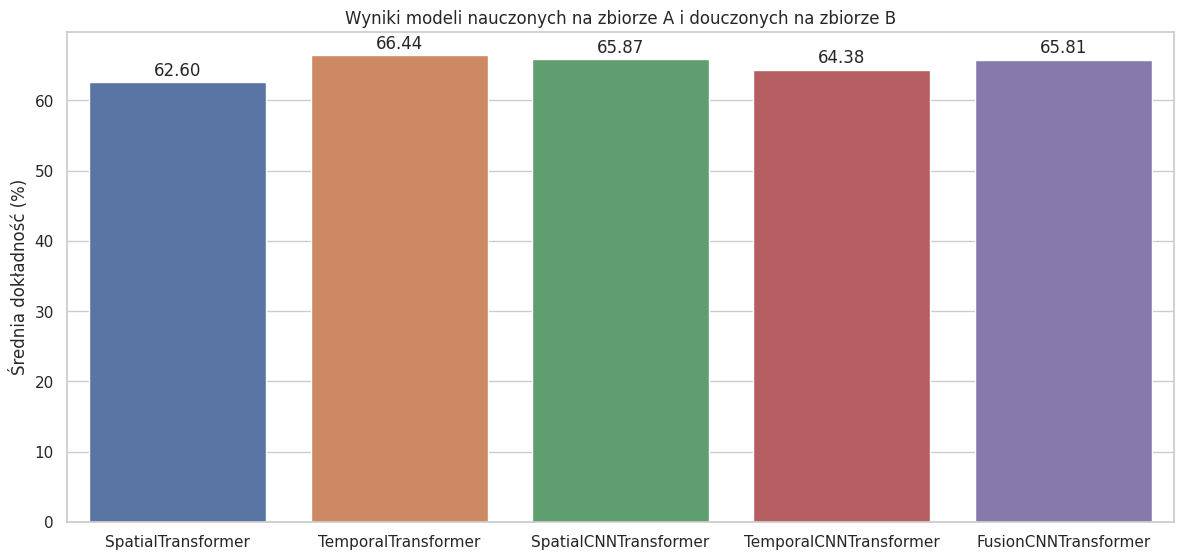

In [22]:
plot_data = {
    "Model": [
        "SpatialTransformer",
        "TemporalTransformer",
        "SpatialCNNTransformer",
        "TemporalCNNTransformer",
        "FusionCNNTransformer",
    ],
    "Średnia dokładność (%)": [
        model_final_accuracies[f"{ModelType.SpatialTransformer}_finetune"],
        model_final_accuracies[f"{ModelType.TemporalTransformer}_finetune"],
        model_final_accuracies[f"{ModelType.SpatialCNNTransformer}_finetune"],
        model_final_accuracies[f"{ModelType.TemporalCNNTransformer}_finetune"],
        model_final_accuracies[f"{ModelType.FusionCNNTransformer}_finetune"],
    ],
}

# Create DataFrame
df = pd.DataFrame(plot_data)

# Set plot style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=df, x="Model", y="Średnia dokładność (%)")

# Annotate bars with values
for container in barplot.containers:
    barplot.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12, padding=2)

# Improve layout
plt.title("Wyniki modeli nauczonych na zbiorze A i douczonych na zbiorze B")
plt.tight_layout()
plt.xlabel("")

# Show plot
plt.show()